### Tensor component analysis of Platelet RNASeq data
Anna Konstorum (<anna.konstorum@yale.edu>)  

In [1]:
# import packages
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2,venn3
import matplotlib
import numpy as np 
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as sm
import scipy.cluster.hierarchy as sch
from PIL import Image
import warnings
from mvlearn.embed.utils import select_dimension
from matplotlib import cm
import scipy.io
from gprofiler import GProfiler
from statannot import add_stat_annotation
warnings.filterwarnings("ignore") 

%matplotlib inline

/Users/akonsto/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
os.chdir('~/code/')
from TD_postprocess_functions import *

<Figure size 432x288 with 0 Axes>

## Metrics including *error* and *similarity score* for finding optimal rank of decomposition
See [Williams et al., 2018](https://doi.org/10.1016/j.neuron.2018.05.015) for elaboration on these metrics

Text(0.5, 1.0, 'Similarity')

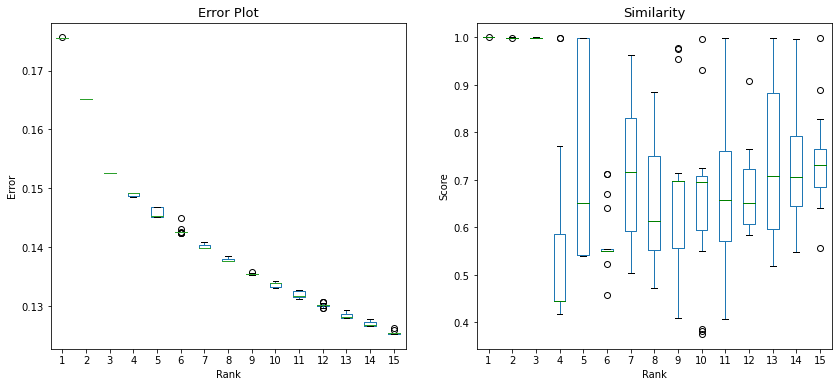

In [3]:
results_dir = '~/results/' 
data_dir = '~/data/'

os.chdir(results_dir)
Merr = pd.read_csv("Merr_tot_mat_platelet.csv",sep=',',header=None)
Mscore = pd.read_csv("Mscore_tot_mat_platelet.csv",sep=',',header=None)

os.chdir(data_dir)
ensg_symbol = pd.read_csv('ENSG_SYMBOL.csv',sep=',',header='infer',index_col=0)

Merr.index=Merr.index+1
Mscore.index=Mscore.index+1

# drop rows of all zeros
Merr = Merr[(Merr!=0).all(axis=1)]
Mscore = Mscore[(Mscore!=0).all(axis=1)]

fig = plt.figure(figsize=(14,6))
ax1=plt.subplot(121)
ax2=plt.subplot(122)

ax1_set=Merr.T.plot(kind='box',ax=ax1)
ax1_set.set_xlabel('Rank');
ax1_set.set_ylabel('Error');
ax1_set.set_title('Error Plot',fontsize=13)

ax2_set=Mscore.T.plot(kind='box',ax=ax2, boxprops=dict(color='tab:blue'),medianprops=dict(color='green'),
                      whiskerprops=dict(color='tab:blue'))
ax2_set.set_xlabel('Rank');
ax2_set.set_ylabel('Score');
ax2_set.set_title('Similarity',fontsize=13)

### Import original tensor and metadata

In [4]:
os.chdir(data_dir)

slice_day_0 = pd.read_csv('slice_day_0_r.csv',sep=',',header='infer',index_col=0)
slice_day_2 = pd.read_csv('slice_day_2_r.csv',sep=',',header='infer',index_col=0)
slice_day_7 = pd.read_csv('slice_day_7_r.csv',sep=',',header='infer',index_col=0)
slice_day_28 = pd.read_csv('slice_day_28_r.csv',sep=',',header='infer',index_col=0)

rank=5
col_names=[]
for i in range(1,rank+1):
    col_names.append('c'+str(i))
    
os.chdir(results_dir)
genes_M = pd.read_csv('genes_M5opt80.csv',header=None)
genes_M.index=slice_day_2.index
genes_M.columns=col_names

samples_M = pd.read_csv('samples_M5opt80.csv',header=None)
samples_M.index=slice_day_2.columns
samples_M.columns=col_names

study_M = pd.read_csv('study_M5opt80.csv',header=None)
study_M.index=('Day0','Day 2','Day 7', 'Day 28')
study_M.columns=col_names

os.chdir(data_dir)

samples_data = pd.read_csv('Platelet_samples_metadata.csv',sep=',',header='infer',index_col=0)
samples_data_s=samples_data[samples_data['Day']==0]
subject_data = samples_data_s[['Response','Age group','Biological sex','Cohort','Subject', 'Age', 'Group']]
subject_data.index=subject_data['Subject'].astype('str')
subject_data.drop(columns='Subject',inplace=True)
subject_data_f = subject_data.loc[slice_day_2.columns]

### Calculate correlations between components and clinical/demographic characteristics

In [5]:
samples_MC = samples_M.copy()
corr_sample_1=pd.DataFrame(index = samples_MC.columns,columns=['corr_age','pvalue_age',
                                                              'KWgroup','pvalue_g',
                                                              'MWu_sex','pvalue_s',
                                                              'MWu_Response','pvalue_r'])
corr_sample_2=pd.DataFrame(index = samples_MC.columns,columns=['MWu_R_Y','pvalue_r_Y',
                                                              'MWu_sex_Y','pvalue_s_Y',
                                                              'MWu_R_O','pvalue_r_O',
                                                              'MWu_sex_O','pvalue_s_O',
                                                              'MWu_R_N','pvalue_r_N',
                                                              'MWu_sex_N','pvalue_s_N',
                                                              ])
corr_sample_3 = pd.DataFrame(index=samples_MC.columns,columns = ['Corr_max','pvalue_max'])

dim = samples_MC.shape[1]
age = subject_data_f['Age']

s_d_f=subject_data_f.copy()

for factor in samples_MC.columns:
    scores = pd.DataFrame(samples_MC[factor])
    corr,pvalue = stats.spearmanr(scores, age)
    corr_sample_1.loc[factor,'corr_age'] = round(corr,2)
    corr_sample_1.loc[factor,'pvalue_age'] = "{:.2e}".format(pvalue) 
    
    scores_F = scores.loc[s_d_f[s_d_f['Biological sex']=='F'].index]
    scores_M = scores.loc[s_d_f[s_d_f['Biological sex']=='M'].index]
    MWu_sex,pvalue_g = stats.mannwhitneyu(scores_F,scores_M, alternative='two-sided')
    corr_sample_1.loc[factor,'MWu_sex'] = round(MWu_sex,2)
    corr_sample_1.loc[factor,'pvalue_s'] = "{:.2e}".format(pvalue_g)
    
    scores_Frail = scores.loc[s_d_f[s_d_f['Group']=='Older (SNF)'].index]
    scores_Young = scores.loc[s_d_f[s_d_f['Group']=='Young'].index]
    scores_Older = scores.loc[s_d_f[s_d_f['Group']=='Older (Comm)'].index]
    KWagegroup,pvalue_ag = stats.kruskal(scores_Frail,scores_Young,scores_Older)
    corr_sample_1.loc[factor,'KWgroup'] = round(KWagegroup,2)
    corr_sample_1.loc[factor,'pvalue_g'] = "{:.2e}".format(pvalue_ag)
    
    scores_High = scores.loc[s_d_f[s_d_f['Response']=='High'].index]
    scores_Low = scores.loc[s_d_f[s_d_f['Response']=='Low'].index]
    MWu_response,pvalue_r = stats.mannwhitneyu(scores_High,scores_Low,alternative='two-sided')
    corr_sample_1.loc[factor,'MWu_Response']=round(MWu_response,2)
    corr_sample_1.loc[factor,'pvalue_r']="{:.2e}".format(pvalue_r)
    
    s_y = s_d_f[s_d_f['Group']=='Young']
    scores_Young = scores.loc[s_y.index]
    scores_High = scores_Young.loc[s_y[s_y['Response']=="High"].index]
    scores_Low = scores_Young.loc[s_y[s_y['Response']=="Low"].index]
    MWu_response,pvalue_r=stats.mannwhitneyu(scores_High,scores_Low,alternative="two-sided")
    corr_sample_2.loc[factor,'MWu_R_Y'] = round(MWu_response,2)
    corr_sample_2.loc[factor,'pvalue_r_Y'] = "{:.2e}".format(pvalue_r)
    scores_F = scores.loc[s_y[s_y['Biological sex']=='F'].index]
    scores_M = scores.loc[s_y[s_y['Biological sex']=='M'].index]
    MWu_sex,pvalue_g = stats.mannwhitneyu(scores_F,scores_M, alternative='two-sided')
    corr_sample_2.loc[factor,'MWu_sex_Y'] = round(MWu_sex,2)
    corr_sample_2.loc[factor,'pvalue_s_Y'] = "{:.2e}".format(pvalue_g)
    
    s_o = s_d_f[s_d_f['Group']=='Older (Comm)']
    scores_O = scores.loc[s_o.index]
    scores_High = scores_O.loc[s_o[s_o['Response']=="High"].index]
    scores_Low = scores_O.loc[s_o[s_o['Response']=="Low"].index]
    MWu_response,pvalue_r=stats.mannwhitneyu(scores_High,scores_Low,alternative="two-sided")
    corr_sample_2.loc[factor,'MWu_R_O'] = round(MWu_response,2)
    corr_sample_2.loc[factor,'pvalue_r_O'] = "{:.2e}".format(pvalue_r)
    scores_F = scores_O.loc[s_o[s_o['Biological sex']=='F'].index]
    scores_M = scores_O.loc[s_o[s_o['Biological sex']=='M'].index]
    MWu_sex,pvalue_g = stats.mannwhitneyu(scores_F,scores_M, alternative='two-sided')
    corr_sample_2.loc[factor,'MWu_sex_O'] = round(MWu_sex,2)
    corr_sample_2.loc[factor,'pvalue_s_O'] = "{:.2e}".format(pvalue_g)
    
    s_n = s_d_f[s_d_f['Group']=='Older (SNF)']
    scores_N = scores.loc[s_n.index]
    scores_High = scores_N.loc[s_n[s_n['Response']=="High"].index]
    scores_Low = scores_N.loc[s_n[s_n['Response']=="Low"].index]
    MWu_response,pvalue_r=stats.mannwhitneyu(scores_High,scores_Low,alternative="two-sided")
    corr_sample_2.loc[factor,'MWu_R_N'] = round(MWu_response,2)
    corr_sample_2.loc[factor,'pvalue_r_N'] = "{:.2e}".format(pvalue_r)
    scores_F = scores_N.loc[s_n[s_n['Biological sex']=='F'].index]
    scores_M = scores_N.loc[s_n[s_n['Biological sex']=='M'].index]
    MWu_sex,pvalue_g = stats.mannwhitneyu(scores_F,scores_M, alternative='two-sided')
    corr_sample_2.loc[factor,'MWu_sex_N'] = round(MWu_sex,2)
    corr_sample_2.loc[factor,'pvalue_s_N'] = "{:.2e}".format(pvalue_g)

In [6]:
corr_sample_1

corr_age pvalue_age KWgroup  pvalue_g MWu_sex  pvalue_s MWu_Response  \
c1    -0.52   5.92e-05   23.97  6.23e-06     346  8.61e-01           98   
c2     0.55   1.80e-05   25.92  2.35e-06     365  8.89e-01          160   
c3     0.51   8.73e-05    25.8  2.50e-06   343.5  8.27e-01          161   
c4    -0.55   1.40e-05   28.67  5.96e-07     373  7.79e-01           96   
c5     0.27   4.79e-02   11.02  4.04e-03     362  9.30e-01          149   

    pvalue_r  
c1  2.73e-01  
c2  2.26e-01  
c3  2.13e-01  
c4  2.42e-01  
c5  4.28e-01

In [7]:
corr_sample_2

MWu_R_Y pvalue_r_Y MWu_sex_Y pvalue_s_Y MWu_R_O pvalue_r_O MWu_sex_O  \
c1      11   1.07e-01        40   5.26e-01       8   7.13e-01        30   
c2      39   5.84e-02        74   6.26e-02      11   9.03e-01        33   
c3      33   2.72e-01      56.5   6.01e-01      11   9.03e-01        41   
c4      16   3.33e-01        38   4.33e-01      11   9.03e-01        22   
c5    18.5   5.18e-01        39   4.78e-01      13   5.40e-01        34   

   pvalue_s_O MWu_R_N pvalue_r_N MWu_sex_N pvalue_s_N  
c1   8.75e-01      13   5.40e-01        29   5.32e-01  
c2   9.58e-01       7   5.40e-01        27   4.13e-01  
c3   3.72e-01      11   9.03e-01        28   4.70e-01  
c4   3.18e-01       7   5.33e-01        46   3.55e-01  
c5   8.75e-01      14   3.91e-01        54   9.22e-02

### Visualize Component 2 score in Young High- vs. Low-Responders

Low v.s. High: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.838e-02 U_stat=9.000e+00


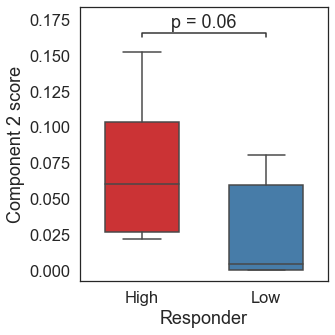

In [8]:
s_y_HL = s_y[s_y['Response']!='Med']
scores = pd.DataFrame(samples_MC['c2'])
s_y_HL['score'] = scores.loc[s_y_HL.index]

cmap_reversed = matplotlib.cm.get_cmap('Set1')
sns.set(font_scale =1.5, style="white")
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

p2=sns.boxplot(y="score",x="Response",data=s_y_HL,palette='Set1',width=0.6, order=['High','Low'])
p2.set_xlabel('Responder')
p2.set_ylabel('Component 2 score')
add_stat_annotation(ax=axes,data=s_y_HL, x='Response', y='score', order=['Low','High'],
                    box_pairs=[("Low","High")],
                    test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)

plt.tight_layout()

### Plot heatmap of clustered samples based on component scores

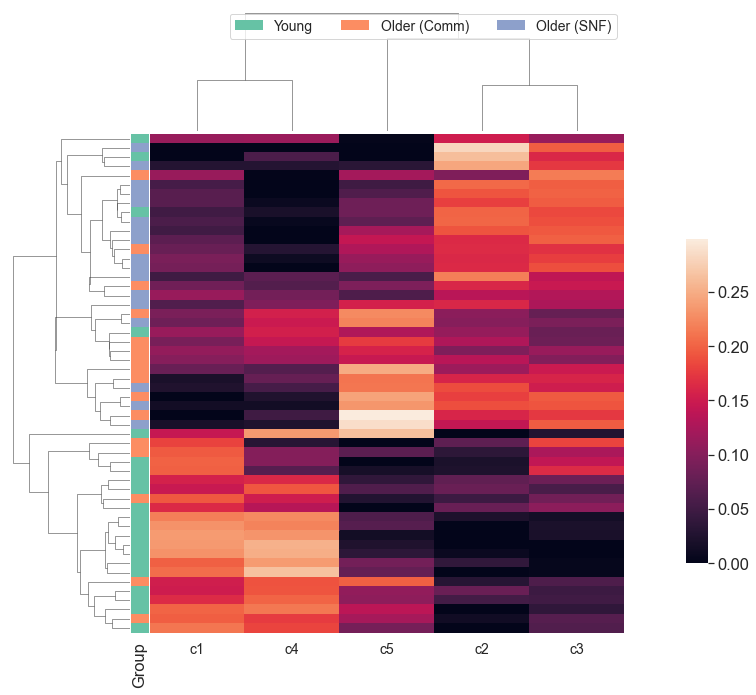

In [9]:
hue_samples_order = ["Young","Older (Comm)","Older (SNF)"]
palette_samples = cm.get_cmap('Set2',8)
ps = [palette_samples(0),palette_samples(1),palette_samples(2)]
age_color=dict(list(zip(hue_samples_order,ps)))

subject_data_f['Group'] = subject_data_f['Group']

cohort = subject_data_f.loc[samples_M.index,'Group']
row_colors = cohort.map(age_color)

g=sns.clustermap(samples_M,method='centroid',row_colors=row_colors, cbar_kws = {'orientation':'vertical'},
                annot_kws={'size':16})
for label in hue_samples_order:
    g.ax_col_dendrogram.bar(0,0, color = age_color[label], label = label, linewidth = 0)
g.ax_col_dendrogram.legend(loc="best",ncol=6,fontsize=14)
g.ax_heatmap.tick_params(labelright=False, right=False,labelsize=14)
g.cax.set_position([.97, .2, .03, .45])

### Perform PCA on samples using component scores as input

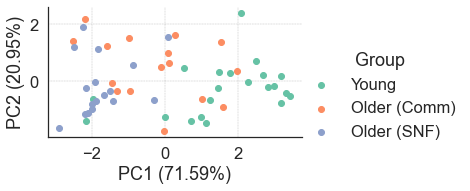

In [10]:
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA

hue_samples_order = ["Young","Older (Comm)", "Older (SNF)"]
palette_samples = cm.get_cmap('Set2',8)
ps = [palette_samples(0),palette_samples(1),palette_samples(2)]
age_color=dict(list(zip(hue_samples_order,ps)))

centered_data = scale(samples_M, with_mean=True, with_std=True)
pca = PCA(n_components=3)
PC_data = pca.fit(centered_data)
PCs = pca.fit_transform(centered_data)
PC_df = pd.DataFrame(PCs, columns=['PC1', 'PC2', 'PC3'])
PC_df.index = samples_M.index
PC_df_full = pd.concat([PC_df, subject_data_f.loc[samples_M.index],samples_M[['c1','c2','c3','c4','c5']]],axis=1)
PC_df_full['Group'] = PC_df_full['Group']

pc_var1 = round(PC_data.explained_variance_ratio_[0]*100,2)
pc_var2 = round(PC_data.explained_variance_ratio_[1]*100,2)

pc1_label = 'PC1 (' + str(pc_var1) + '%)'
pc2_label = 'PC2 (' + str(pc_var2) + '%)'


fg = sns.FacetGrid(data=PC_df_full, hue='Group',hue_order=hue_samples_order, hue_kws={'color': ps}, aspect=1.61)
fg.map(plt.scatter, 'PC1', 'PC2').add_legend()
fg.set_axis_labels(pc1_label,pc2_label)
plt.grid(color='grey', ls = '-.', lw = 0.25)
plt.show()


#### Organize component data and rank by component score

In [11]:
genes_ranked=[]
samples_ranked=[]
study_ranked = []
subjects_ranked = []

for i in range(1,6):
    comp='c'+str(i)
    genes = pd.DataFrame(genes_M[comp])
    genes.columns=['c']
    genes.sort_values(by='c',ascending=False,inplace=True)
    genes_ranked.append(genes)
    
    samples = pd.DataFrame(samples_M[comp])
    samples.columns=['c']
    samples.sort_values(by='c',ascending=False,inplace=True)
    samples_ranked.append(samples)
    
    study = pd.DataFrame(study_M[comp])
    study.columns=['c']
    study_ranked.append(study)
    
    subjects = subject_data_f.loc[samples.index]
    subjects_ranked.append(subjects)

## Explore components

### Component 1

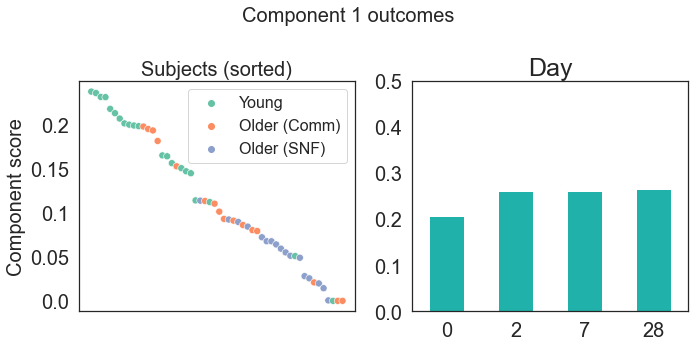

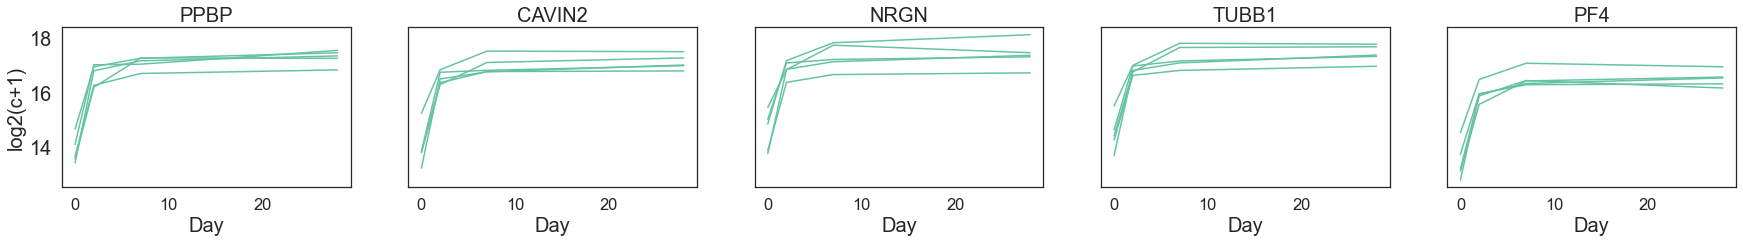

In [12]:
plot_comp('c1',samples_ranked,subjects_ranked, genes_ranked, study_M,'Group')
vis_top_1row('c1',genes_ranked, samples_ranked, ensg_symbol,subject_data_f,
            slice_day_0,slice_day_2,slice_day_7, slice_day_28)

### Component 2

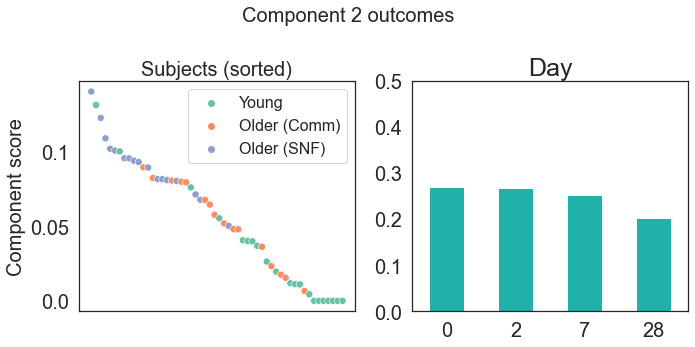

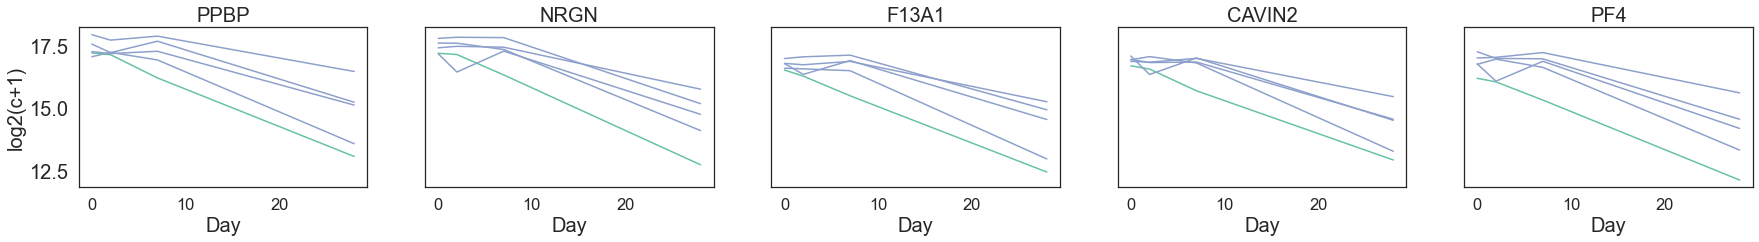

In [13]:
plot_comp('c2',samples_ranked,subjects_ranked, genes_ranked, study_M,'Group')
vis_top_1row('c2',genes_ranked, samples_ranked, ensg_symbol,subject_data_f,
            slice_day_0,slice_day_2,slice_day_7, slice_day_28)

### Component 3

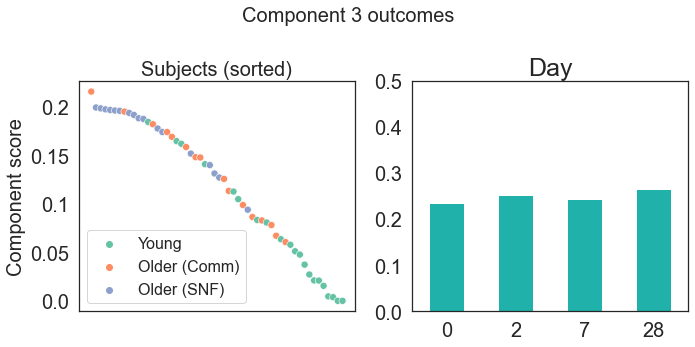

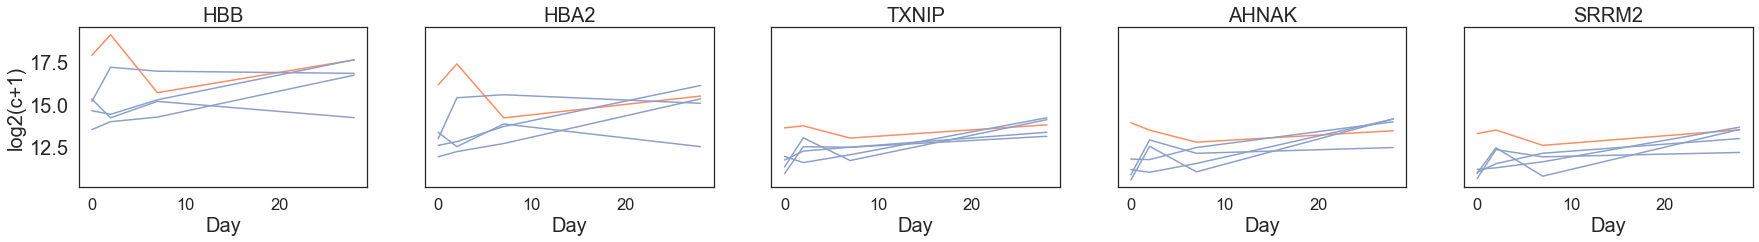

In [14]:
plot_comp('c3',samples_ranked,subjects_ranked, genes_ranked, study_M,'Group')
vis_top_1row('c3',genes_ranked, samples_ranked, ensg_symbol,subject_data_f,
            slice_day_0,slice_day_2,slice_day_7, slice_day_28)

### Component 4

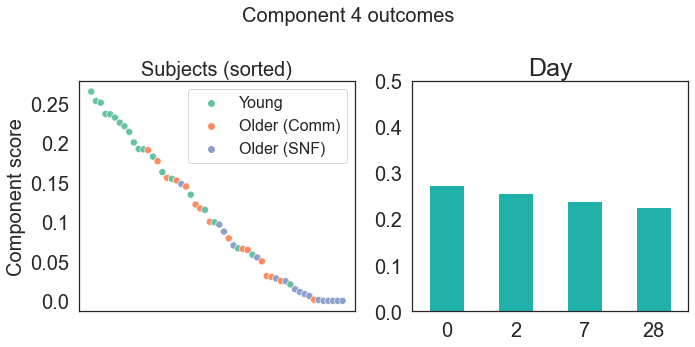

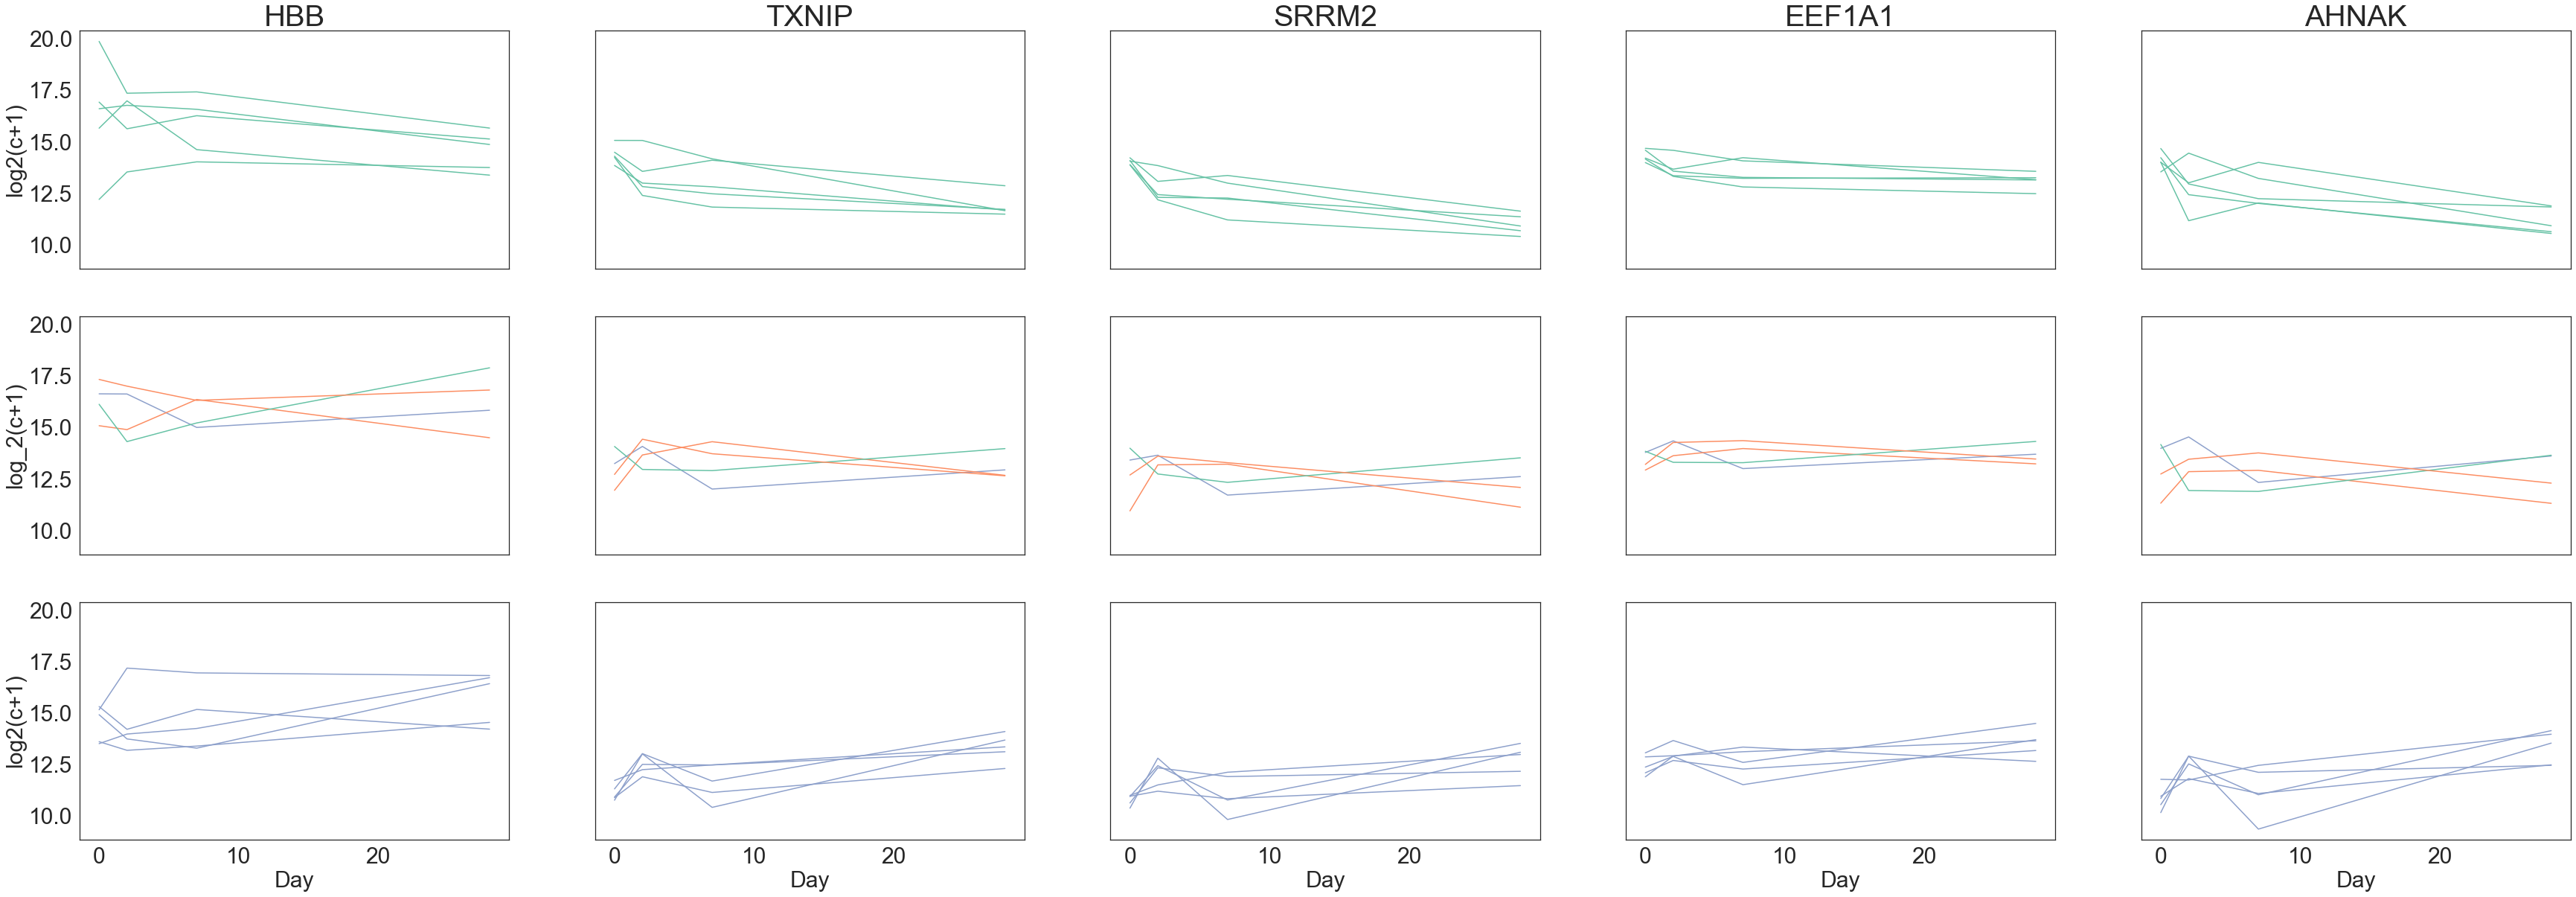

In [15]:
plot_comp('c4',samples_ranked,subjects_ranked, genes_ranked, study_M,'Group')
vis_top('c4',genes_ranked, samples_ranked, ensg_symbol,subject_data_f,
            slice_day_0,slice_day_2,slice_day_7, slice_day_28)

### Component 5

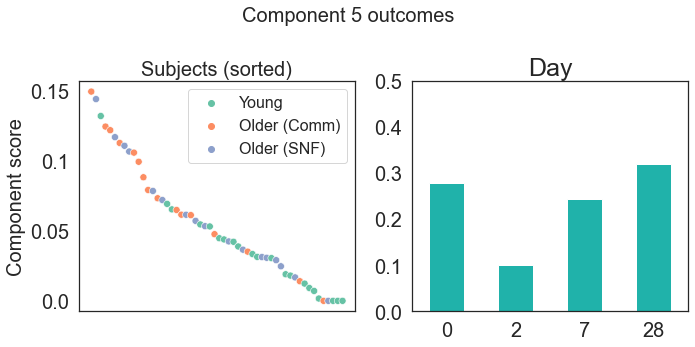

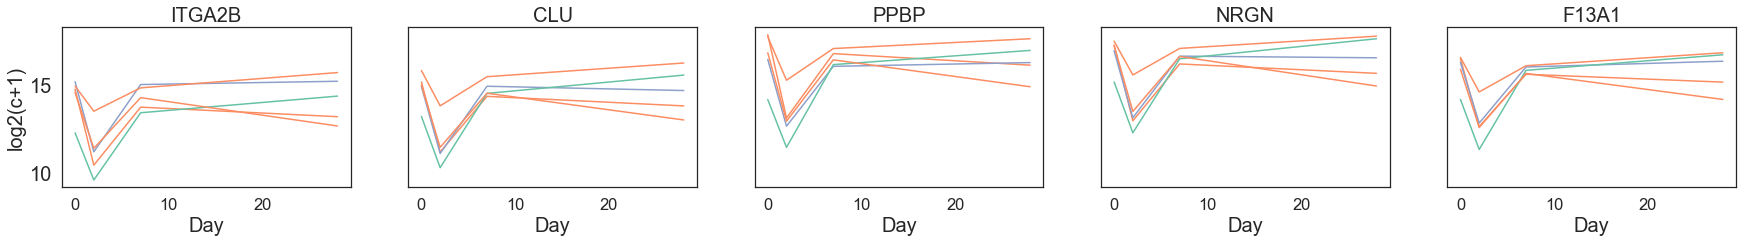

In [16]:
plot_comp('c5',samples_ranked,subjects_ranked, genes_ranked, study_M,'Group')
vis_top_1row('c5',genes_ranked, samples_ranked, ensg_symbol,subject_data_f,
            slice_day_0,slice_day_2,slice_day_7, slice_day_28)

### Plot genes for each component sorted by score

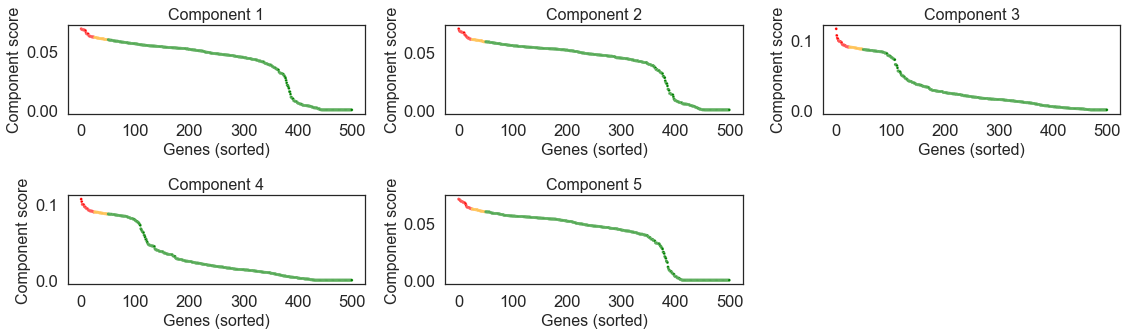

In [17]:
gr_all=plot_genes_sorted(genes_ranked)

#### Obtain top 5% scoring genes for each component

In [18]:
c1_genes_high = top_genes_out('c1',genes_ranked,ensg_symbol,save=True)
c2_genes_high = top_genes_out('c2',genes_ranked,ensg_symbol,save=True)
c3_genes_high = top_genes_out('c3',genes_ranked,ensg_symbol,save=True)
c4_genes_high = top_genes_out('c4',genes_ranked,ensg_symbol,save=True)
c5_genes_high = top_genes_out('c5',genes_ranked,ensg_symbol,save=True)

c1_genes_25 = c1_genes_high.iloc[0:24,]
c2_genes_25 = c2_genes_high.iloc[0:24,]
c3_genes_25 = c3_genes_high.iloc[0:24,]
c4_genes_25 = c4_genes_high.iloc[0:24,]
c5_genes_25 = c5_genes_high.iloc[0:24,]

### Visualize intersection of genes in Components 1,2, and 5

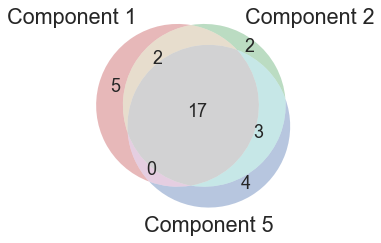

In [19]:
c1_set = set(c1_genes_25['SYM'])
c2_set = set(c2_genes_25['SYM'])
c5_set = set(c5_genes_25['SYM'])

venn3([c1_set,c2_set,c5_set],
     set_labels = ('Component 1','Component 2', 'Component 5'))

### Visualize intersection of genes in Components 3 and 4

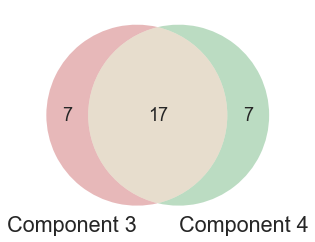

In [20]:
c3_set = set(c3_genes_25['SYM'])
c4_set = set(c4_genes_25['SYM'])

venn2([c3_set,c4_set],
     set_labels = ('Component 3','Component 4'))

### Reactme pathways over-represented by genes in intersection of Comps. 1,2 and 5

In [21]:
c125 = c1_set.intersection(c2_set,c5_set)

gp = GProfiler(return_dataframe=True)
sources = ['REAC']
c125_paths=gp.profile(organism='hsapiens',
            query=list(c125),
            sources=sources,
            no_evidences=False)
c125_paths[['name','p_value']]

name       p_value
0                         Platelet degranulation   2.285499e-10
1    Response to elevated platelet cytosolic Ca2+  3.148151e-10
2  Platelet activation, signaling and aggregation  7.930122e-08
3                                      Hemostasis  2.054517e-07
4            Post NMDA receptor activation events  3.553647e-02

### Reactome pathways over-represented by genes in intersection of Comps. 3 and 4

In [22]:
c34 = c3_set.intersection(c4_set)

gp = GProfiler(return_dataframe=True)
sources = ['REAC']
c34_paths=gp.profile(organism='hsapiens',
            query=list(c34),
            sources=sources,
            no_evidences=False)
c34_paths[['source','name','p_value','intersections']]

source                               name   p_value  \
0   REAC           Peptide chain elongation  0.000014   
1   REAC  Eukaryotic Translation Elongation  0.000017   
2   REAC                        Translation  0.004754   
3   REAC       Cellular responses to stress  0.039461   
4   REAC      Cellular responses to stimuli  0.043739   
5   REAC             Viral mRNA Translation  0.047307   

                                intersections  
0        [EEF2, RPL13A, EEF1A1, RPLP2, RPL19]  
1        [EEF2, RPL13A, EEF1A1, RPLP2, RPL19]  
2        [EEF2, RPL13A, EEF1A1, RPLP2, RPL19]  
3  [TXNIP, RPL13A, EEF1A1, RPLP2, RPL19, HBB]  
4  [TXNIP, RPL13A, EEF1A1, RPLP2, RPL19, HBB]  
5                      [RPL13A, RPLP2, RPL19]